# Quiz 3

In this quiz we were tasked with implementing the Harris corner detector, then measure its robustness and compare it to OpenCv's implementation. The algorithm consists of the following steps:

1. Compute x and y derivative of image using Sobel detection
2. Compute the products of the derivatives
3. Compute the sums of the products of derivatives
4. Using the sums, define at each pixel the matrix of the sums
5. Compute the response of the detector
6. Treshold
7. Nonmax suppression

In [1]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.animation as ani
from matplotlib import rc
import numpy as np
from numpy.fft import ifft2, fft2



We start by defining a function to create synthetic images (`create_pattern`), and another to add noise to an image (`make_noise`). In the first iteration the gaussian noise was added directly to the image matrix, and this worked fine for my implementation, however for OpenCV functions, it does not work as intended. It expects maximum values of 255 for grayscale images, and by adding the gaussian noise directly to the image we get values above that treshold. So it was changed to use `cv2.add` to add the noise to the image,this function clips values that go over 255, back to 255.

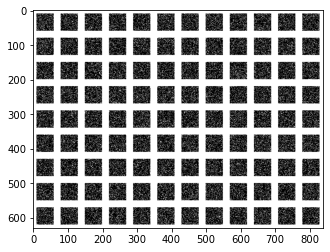

In [2]:
# Here we create a synthetic image and define the noise function, that takes an image and adds gaussian noise to it


def create_pattern(n, m, type="checkers"):
    black_square = np.zeros((50, 50), dtype = np.uint8)
    white_square = np.full((50, 50), 255, dtype = np.uint8)

    if type == "checkers":
        bw = np.concatenate([white_square if x % 2 else black_square for x in range(m)], axis=1)
        wb = np.concatenate([white_square if not x % 2 else black_square for x in range(m)], axis=1)
        ret = np.concatenate([bw if x%2 else wb for x in range(n)])
        ret = np.pad(ret, ((5,5),(5,5)), 'constant', constant_values=255)

        return ret, None

    if type == "aligned":
        black_square = np.pad(black_square, ((10,10), (10,10)), 'constant', constant_values=255)
        row = np.concatenate([black_square for x in range(m)], axis=1)            
        ret = np.concatenate([row for x in range(n)])
        base_coords = [(10,10),(10,59),(59,10),(59, 59)]
        bshape = (70, 70)
        # True corner coordinates
        corners = []
        for i in range(n):
            for j in range(m):
                for x, y in base_coords:
                    corners.append((x+bshape[0]*i, y+bshape[1]*j))
                
        return ret, corners

    raise(NotImplementedError)

def make_noise(img, sigma):
    gauss = np.random.normal(0, sigma, img.shape).astype(np.uint8)
    return cv2.add(img, gauss)

img, true_corners = create_pattern(9,12, type="aligned")
plt.imshow(make_noise(img, 1), cmap='gray')

In [3]:
import math

def np_fftconvolve(A, B):
    # Source: https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html
    # I was looking for convolution methods that did not consist of manually iterating every pixel with a mask, and were fast.
    # I was under the impression that doing the operations in frequency space was far less efficient because of having to 
    # do the Fourier transform, even with fft. But the benchmarks show otherwise.
    return np.real(ifft2(fft2(A)*fft2(B, s=A.shape)))

def gaussian(size, sigma):
    # https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm
    G_s = lambda x, y, s: (1 / (2 * math.pi * (s ** 2))) * math.e ** (
        -(x ** 2 + y ** 2) / (2 * s ** 2)
    )
    ret = np.zeros((size, size))
    for i_x, x in enumerate(range(-(size - 1) // 2, (size - 1) // 2 + 1)):
        for i_y, y in enumerate(reversed(range(-(size - 1) // 2, (size - 1) // 2 + 1))):
            ret[i_x, i_y] = G_s(x, y, sigma)
    return ret

After defining the convolution function (`np_fftconvolve`) and the gaussian matrix generator function (`gaussian`), we can implement the Harris Corner Detector. Details can be seen in the implementation itself.

In [4]:

def harris_corners(img, tau, k, sigma):
    # Compute x and y derivative of image (Sobel)
    S_y = np.array([[-1, -2, -1], [0, 0 , 0], [1, 2 ,1]])
    S_x = np.array([[-1, -2, -1], [0, 0 , 0], [1, 2 ,1]]).transpose()
    I_y = np_fftconvolve(img, S_y)
    I_x = np_fftconvolve(img, S_x)

    # Compute products of derivative at every pixel
    I_x2 = I_x**2
    I_y2 = I_y**2
    I_xy = I_x * I_y

    # Compute the sums of the products of derivatives at each pixel
    G = gaussian(5, sigma)
    S_x2 = np_fftconvolve(I_x2, G)
    S_y2 = np_fftconvolve(I_y2, G)
    S_xy = np_fftconvolve(I_xy, G)

    # Compute the response of the detector at each pixel
    R = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            M = np.array([[S_x2[i, j], S_xy[i, j]], 
                          [S_xy[i, j], S_y2[i, j]] ])
            R[i, j] = np.linalg.det(M) - k*((np.trace(M))**2)

    # Something in this implementation offsets R. I could not find what did it, 
    # but the offset seems to be constant, so we undo it here.
    R = R[3:, 3:]
    R = np.pad(R,((0, 3),(0, 3)), 'constant')

    # Treshold on value of R
    R[R < tau*R.max()] = 0

    # Compute nonmax suppression
    aux = np.copy(R)
    for i in range(2, R.shape[0]-2):
        for j in range(2, R.shape[1]-2):
            m = R[i-2:i+3, j-2:j+3].max()
            if R[i, j] < m:
                aux[i, j] = 0

    
    return aux


Here we define the function that calculates the root mean square error (`calc_rmse`), this function also returns the number of missed corners and the number of spurious corners. To do this we iterate the real corners of the image, and for each corner we search for the closest detected corner. Then we only consider the closest corner and the actual corner to be the same, if their distance is lesser than 3. This is done because otherwise any spurious corner could cover for a missed corner, and we wouldn't detect neither. This is not flawless however, we don't have any way of knowing if the closest detected corner to an actual corner is actually the same, or is just product of the noise.

In [5]:
def calc_rmse(found, expected):
    found = [(arr[0], arr[1]) for arr in list(found)]

    expected = list(expected)
    spurious = found.copy()

    squares = 0
    missed = []
    for point in expected:
        closest = min(spurious, key=lambda x: math.dist(x, point))
        dist = math.dist(closest, point)
        if dist <= 3:
            # Is the same corner
            squares += dist**2
            spurious.remove(closest)
        else:
            missed.append(point)

    rmse = math.sqrt(squares/(len(found)-len(spurious)))
    return rmse, len(missed), len(spurious)
  

In [6]:
# This function generates experimental data for our implementation
def get_noisy_data(n, true_corners):
    data = {}
    for i in np.linspace(0, 20, n):
        img_corners = harris_corners(make_noise(img, i), 0.01, 0.04, 1)
        corner_coords = np.argwhere(img_corners > 0)
        data[i] = calc_rmse(corner_coords, true_corners)
    return data


In [7]:
img_corners = harris_corners(img, 0.01, 0.04, 1)
corner_coords = np.argwhere(img_corners > 0)
noisy_data = get_noisy_data(100, true_corners)
plt.figure(figsize=(10,10))
plt.imshow(img_corners, cmap="gray")

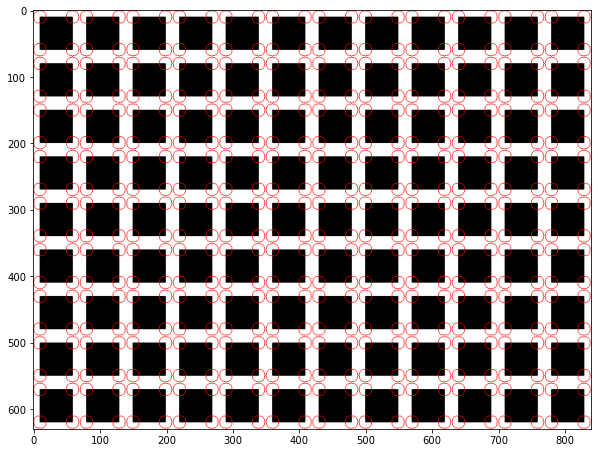

In [ ]:

highlighted = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
highlighted[img_corners > 0] = [255, 0, 0]

for point in corner_coords:
    cv2.circle(highlighted, (point[1], point[0]), 10, (255,0, 0))
    
plt.figure(figsize=(10,10))
plt.imshow(highlighted)

In [ ]:
# This function generates experimental data for OpenCv's implementation
def cv2_get_noisy_data(n, true_corners):
    data = {}
    for i in np.linspace(0, 20, n):
        noisy = make_noise(img, i)
        # blockSize=2, aperture size sobel = 3, k =0.04
        dst = cv2.cornerHarris(noisy,2,3,0.04)
        # Threshold for an optimal value, it may vary depending on the image.
        dst[dst < 0.01*dst.max()] = 0

        # Compute nonmax suppression
        aux = np.copy(dst)
        for k in range(2, dst.shape[0]-2):
            for j in range(2, dst.shape[1]-2):
                m = dst[k-2:k+3, j-2:j+3].max()
                if dst[k, j] < m:
                    aux[k, j] = 0

        corner_coords = np.argwhere(aux > 0)
        result = calc_rmse(corner_coords, true_corners)
        data[i] = result
    return data



cv2_noisy_data = cv2_get_noisy_data(100, true_corners)

What follows are the plots for visualizing the experimental data, the x axis represent increasing levels of noise for all plots. The first is the root mean square error, followed by the missed corners, and lastly the spurious corners.

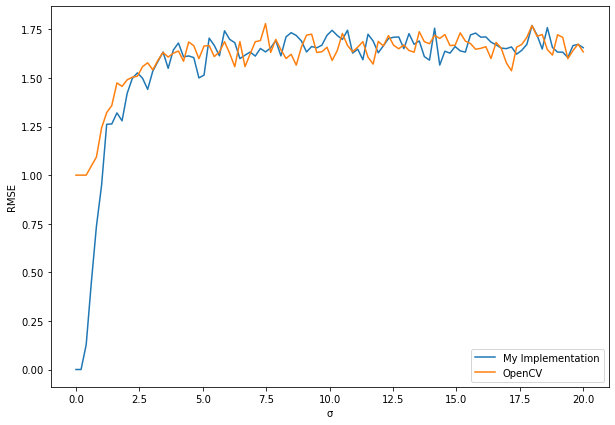

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

plt.xlabel("σ")
plt.ylabel("RMSE")
plt.plot(noisy_data.keys(), [v[0] for v in noisy_data.values()], label="My Implementation")
plt.plot(cv2_noisy_data.keys(), [v[0] for v in cv2_noisy_data.values()], label="OpenCV")
ax.legend()



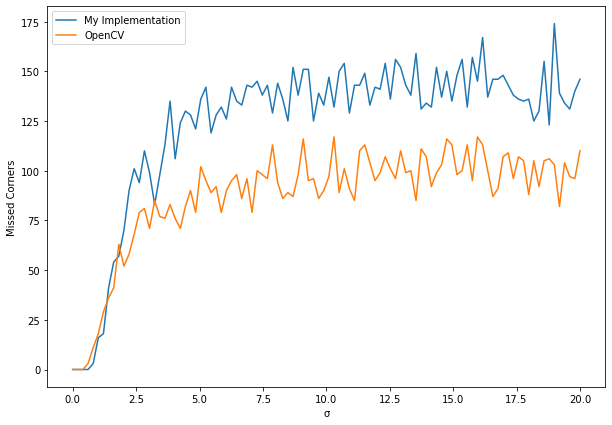

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
plt.xlabel("σ")
plt.ylabel("Missed Corners")

plt.plot(noisy_data.keys(), [v[1] for v in noisy_data.values()], label="My Implementation")
plt.plot(cv2_noisy_data.keys(), [v[1] for v in cv2_noisy_data.values()], label="OpenCV")
ax.legend()


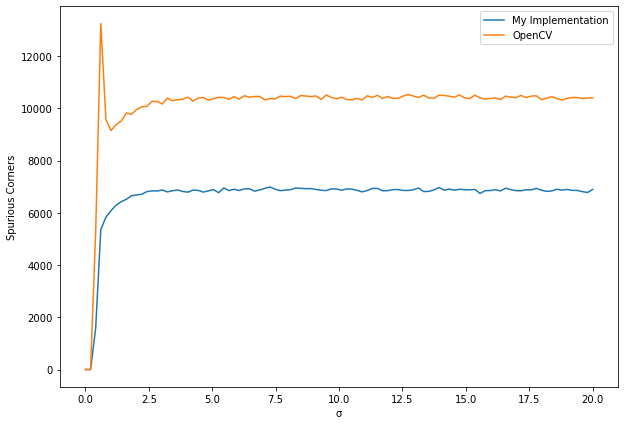

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
plt.xlabel("σ")
plt.ylabel("Spurious Corners")

plt.plot(noisy_data.keys(), [v[2] for v in noisy_data.values()], label="My Implementation")
plt.plot(cv2_noisy_data.keys(), [v[2] for v in cv2_noisy_data.values()], label="OpenCV")
ax.legend()

## Conclusion
These results show good performance on my implementation, however some of the data might be misleading. The first graph shows that opencv's rmse starts at 1, while my implementation starts at 0. This happens because nonmax supression on OpenCV's initial result makes some pixels further from the real corner (While some are spot on). This offset could also affect the missed corners and spuriours corners. With this said, the greater ammount of spurrious corners detected by OpenCV's implementation probably impacted the number of missed corners, since a greater ammount of spurious corners, would increase the likelyhood that one of such corners was sufficiently close to a real corner. This would cause the algorithm to consider the spurious corner a real corner, and the missed corner a not-missed corner. But besides that, the differences in the results seem to be at a constant factor, and leads me to believe that my implementation peforms well, even when compared to OpenCV's implementation.


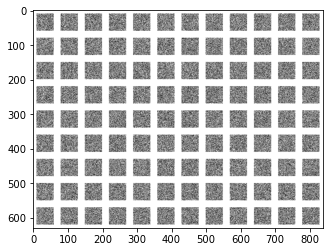

In [ ]:
# Animation showing increasing ammounts of Gaussian Noise
fig = plt.figure()

im = plt.imshow(img, cmap="gray")

def make_noisy(i):
    im.set_array(make_noise(img, i))
    return [im]
rc('animation', html='html5')
anim = ani.FuncAnimation(fig, make_noisy, 200, interval=50)
anim

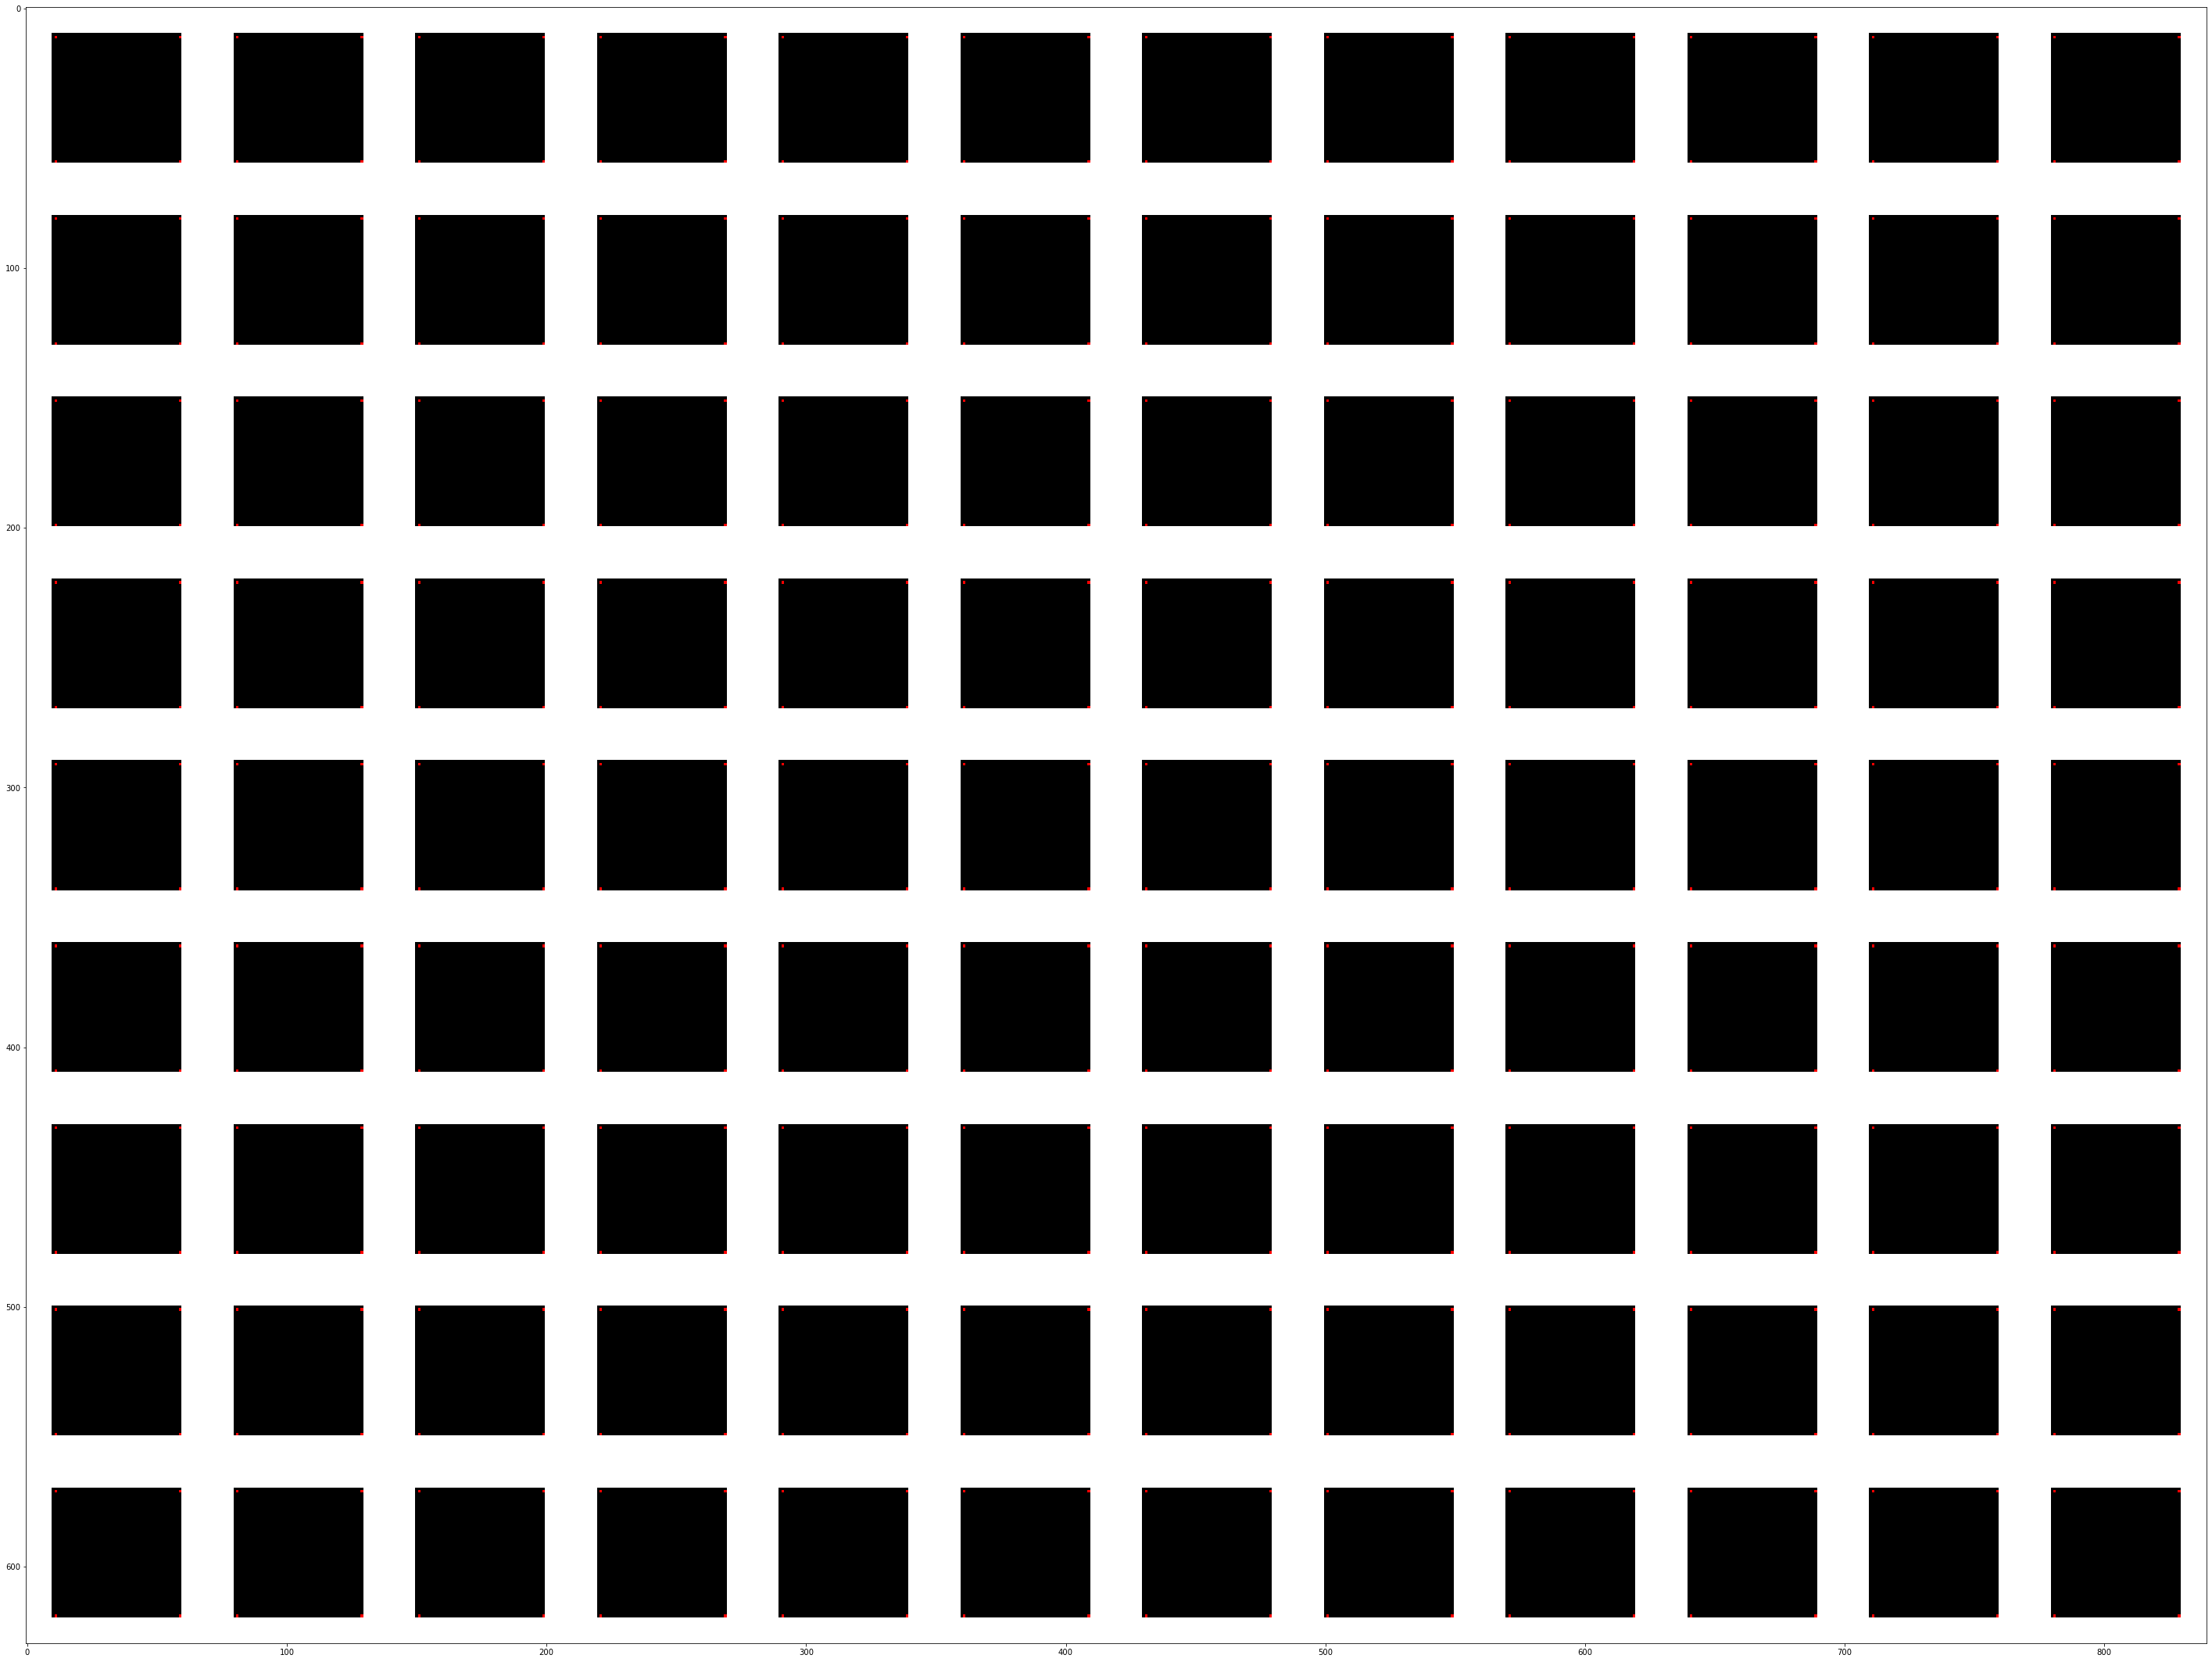

In [ ]:
img2 = np.copy(img)
plt.figure(figsize=(50,50))
    
# blockSize=2, aperture size sobel = 3, k =0.04
dst = cv2.cornerHarris(img2,2,3,0.04)
# Threshold for an optimal value, it may vary depending on the image.
dst[dst < 0.01*dst.max()] = 0
# Compute nonmax suppression
aux = np.copy(dst)
for k in range(2, dst.shape[0]-2):
    for j in range(2, dst.shape[1]-2):
        m = dst[k-2:k+3, j-2:j+3].max()
        if dst[k, j] < m:
            aux[k, j] = 0
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
img2[aux > 0] = [255,0,0]
plt.imshow(img2)

In [ ]:
import numpy as np
import math

In [ ]:
A = np.array([[1, math.e, math.e**(-1)],[1, math.e**1.5, math.e**(-1.5)],[1, math.e**2, math.e**(-2)],[1, math.e**2.5, math.e**(-2.5)],[1, math.e**3, math.e**(-3)]])
b = np.array([[1.1],[1.2],[1.3],[1.3],[1.4]])
np.linalg.lstsq(A, b)

<ipython-input-2-89174989048e>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(A, b)


(array([[ 1.3247933 ],
        [ 0.00482768],
        [-0.64107051]]),
 array([0.00177037]),
 3,
 array([25.24730906,  1.29791016,  0.12714035]))